# Tool for use in screening ligands using a Trained XGBoost model and Constructed Dataset

Author: Wylie Kau, Last Edit: 2/22/2025

v4

Notes
- 

## Imports

In [1]:
# imports
import matplotlib.pyplot as plt
from matplotlib.patches import Patch
import seaborn as sns
import numpy as np
import pandas as pd
import rdkit
import rdkit.Chem as Chem
from rdkit.Chem import Draw, Lipinski, Crippen, Descriptors
from rdkit.Chem.Draw import rdMolDraw2D
from IPython.display import SVG
import pubchempy as pcp
import re
from datetime import datetime
import pickle
import os
import inspect

plt.style.use('wfk')

## Helper Functions & Constants

In [2]:
def iupac_from_smiles(smiles):
    try:
        compound = pcp.get_compounds(smiles, 'smiles')[0]
        return compound.iupac_name
    except:
        return 'N/A'
    
def get_smiles(ligand):
    if ligand is None:
        return None
    compounds = pcp.get_compounds(ligand, 'name')
    if compounds:
        return compounds[0].isomeric_smiles
    return None

def to_canonical_smiles(smiles):
    mol = rdkit.Chem.MolFromSmiles(smiles)
    return rdkit.Chem.MolToSmiles(mol, canonical=True)

def C_to_K(C):
    return C + 273.15

def calc_dG_fromK(K, T):
    try:
        if K == 0.0:
            return None
        return - R_kcpm * T * np.log(K)
    except:
        return None
    
def mean_val(x1, x2):
    return np.nanmean((x1, x2))

def contains_any_substring(string, substrings):
    return any(substring in string for substring in substrings)

def dG_to_K(dG, T=298.15, R=1.987E-03): # (dG in kcal/mol, T=298.15 K, R=1.987E-03 kcal/(mol*K))
    return np.exp(-dG / (R * T))

In [3]:
# Get all the functions from the Lipinski and Crippen modules for use
mol_descriptors = [(nm, fn) for nm, fn in Descriptors.descList]
#print(mol_descriptors)
lipinski_funcs = [(nm, fn) for nm, fn in inspect.getmembers(Lipinski) if inspect.isfunction(fn)]
#print(lipinski_funcs)
crippen_funcs = [(nm, fn) for nm, fn in inspect.getmembers(Crippen) if inspect.isfunction(fn)]
#print(crippen_funcs)

skip_funcs = ['_HAcceptors', '_HDonors', '_HDonors', '_Heteroatoms', '_RotatableBonds', '_fn',
                'FpDensityMorgan3', '_Init', '_ReadPatts', '_pyGetAtomContribs', '_pyMolLogP', '_pyMolMR']

def encode_molecule(SMILES_string, missingVal=None):


    mol = rdkit.Chem.MolFromSmiles(SMILES_string)
    mol_encoding_dict = {}

    # Iterate through rdkit.Chem.Descriptors function
    for nm, fn in Descriptors.descList:
        if nm in skip_funcs:
            continue
        try: 
            val = fn(mol)
        except:
            traceback.print_exc()
            val = missingVal
            
        mol_encoding_dict[nm] = val

    # Iterate through Lipinski molecular descriptors
    for nm, fn in lipinski_funcs:
        if nm in skip_funcs:
            continue
        try: 
            val = fn(mol)

        except:
            traceback.print_exc()
            val = missingVal
            
        mol_encoding_dict[nm] = val

    # Iterate through Crippen molecular descriptors
    for nm, fn in crippen_funcs:
        if nm in skip_funcs:
            continue
        try: 
            val = fn(mol)
        except:
            traceback.print_exc()
            val = missingVal
            
        mol_encoding_dict[nm] = val

    # break up data into features and names
    features = list(mol_encoding_dict.keys())
    mol_encoding = list(mol_encoding_dict.values())

    return mol_encoding, features

In [4]:
T = C_to_K(25) # RT in K

## Data Imports

In [5]:
# Import the dataset used in initial model training
df_path = "../Outputs/Featurized NIST46 Dataset for Model Training/AllMolEncodings+set5-2_ion-encodings.csv"
df = pd.read_csv(df_path)
ephiles = df['Electrophile'].unique()

# Import the constructed dataset
df_dG_path = '../Outputs/Augmented NIST46 Dataset/XGBRegressor_dGConstructed_20250313_164038.csv'
df_dG = pd.read_csv(df_dG_path)

# Import the electrophile dataset
df_e_path = '../Data/ephile properties_cleaned.xlsx'
df_e = pd.read_excel(df_e_path, sheet_name='Set5')

# note which columns are features and which are not
non_features = ['delta_G', 'smiles', 'Electrophile', 'Ligand']
all_features = [i for i in df.columns if i not in non_features]
ep_features = [i for i in df_e.columns if i not in non_features]
ep_features = [i for i in ep_features if i in all_features]
l_features = [i for i in all_features if i not in ep_features]

## Model Imports

In [6]:
# Import trained model with predicted error details
model_dir = '../Outputs/Fitted Models/XGBoost_HalvingGridSearchCV_20250313_163658'
model_path = os.path.join(model_dir, 'model.pkl')
error_df_path = os.path.join(model_dir, 'error_df.csv')

with open(model_path, 'rb') as file:
    model = pickle.load(file)

model_class = model.__class__.__name__
print(f"Model Class: {model_class}")

# Load error_df
error_df = pd.read_csv(error_df_path)
display(error_df)

# Convert error_df into an error dictionary
error_dict = error_df.set_index('Error Category')['RMSE [kcal/mol]'].to_dict()

model_rmse_ligand_out_of_set_error = error_dict['Unobserved Ligand'] # kcal/mol error

print(f"Loaded Model: {model}\n\nRMSE Error: {model_rmse_ligand_out_of_set_error} kcal/mol")

Model Class: XGBRegressor


,Error Category,RMSE [kcal/mol]
0,Mg2+,0.170554
1,Ca2+,0.259343
2,Sr2+,0.173171
3,La3+,0.117529
4,Pr3+,0.086776
5,Nd3+,0.079208
6,Sm3+,0.124234
7,Gd3+,0.104659
8,Tb3+,0.065223
9,Dy3+,0.066843


Loaded Model: XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.5, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=0, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.01, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=8, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=800, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

RMSE Error: 0.2808254523277764 kcal/mol


## Screen User-Selected Ligands

Input Ligand Name: pyridine --> Output Smiles: c1ccncc1


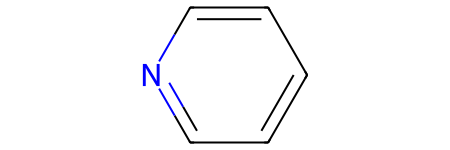

In [7]:
# Use this cell to figure out what the input smiles strings are for ligands of interest.
ligand_in = "pyridine"
smiles_out = to_canonical_smiles(get_smiles(ligand_in))
print(f"Input Ligand Name: {ligand_in} --> Output Smiles: {smiles_out}")
mol1 = Chem.MolFromSmiles(smiles_out)
display(mol1)
print()


Input Smiles: c1ccncc1 --> Output Iupac Name: pyridine, Output Canonical Smiles: c1ccncc1


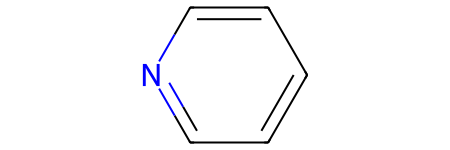

In [8]:
smiles_in = "c1ccncc1"
iupac_out = iupac_from_smiles(smiles_in)
smiles_out = to_canonical_smiles(smiles_in)
print(f"Input Smiles: {smiles_in} --> Output Iupac Name: {iupac_out}, Output Canonical Smiles: {to_canonical_smiles(smiles_in)}")
mol2 = Chem.MolFromSmiles(smiles_in)
display(mol2)

In [9]:
### INPUT DESIRED LIGANDS OF INTEREST
lois_smiles = ['c1ccncc1']# <-- INPUT SMILES STRINGS FOR LIGANDS OF INTEREST HERE

lois_iupac = [iupac_from_smiles(i) for i in lois_smiles]
lois_zip = list(zip(lois_smiles, lois_iupac))
print("Screening Ligands:")
for i in lois_zip:
    print(i[1], i[0])
print()

### SELECT ION-SET OF INTEREST
WFK_SSSorption_e_set = ['Cu2+', 'Ni2+', 'Co2+','Mn2+', 'Mg2+', 'Li+']

e_set = WFK_SSSorption_e_set # <-- CHANGE SELECTION HERE
print("Screening Electrophiles:", e_set)
print()

e_part = 'Li+' # <-- CHANGE PARTITIONING ELECTROPHILE HERE
print(f'Looking at Partitioning with respect to: {e_part}')

### Print out a summary dataframe, if interested
show_dfs = True

Screening Ligands:
pyridine c1ccncc1

Screening Electrophiles: ['Cu2+', 'Ni2+', 'Co2+', 'Mn2+', 'Mg2+', 'Li+']

Looking at Partitioning with respect to: Li+



pyridine c1ccncc1


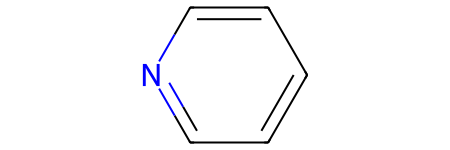

/var/folders/51/1469qh3n09s2ntzgsg9vcfzc0000gn/T/ipykernel_76917/4235471768.py:96: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()
/var/folders/51/1469qh3n09s2ntzgsg9vcfzc0000gn/T/ipykernel_76917/4235471768.py:138: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


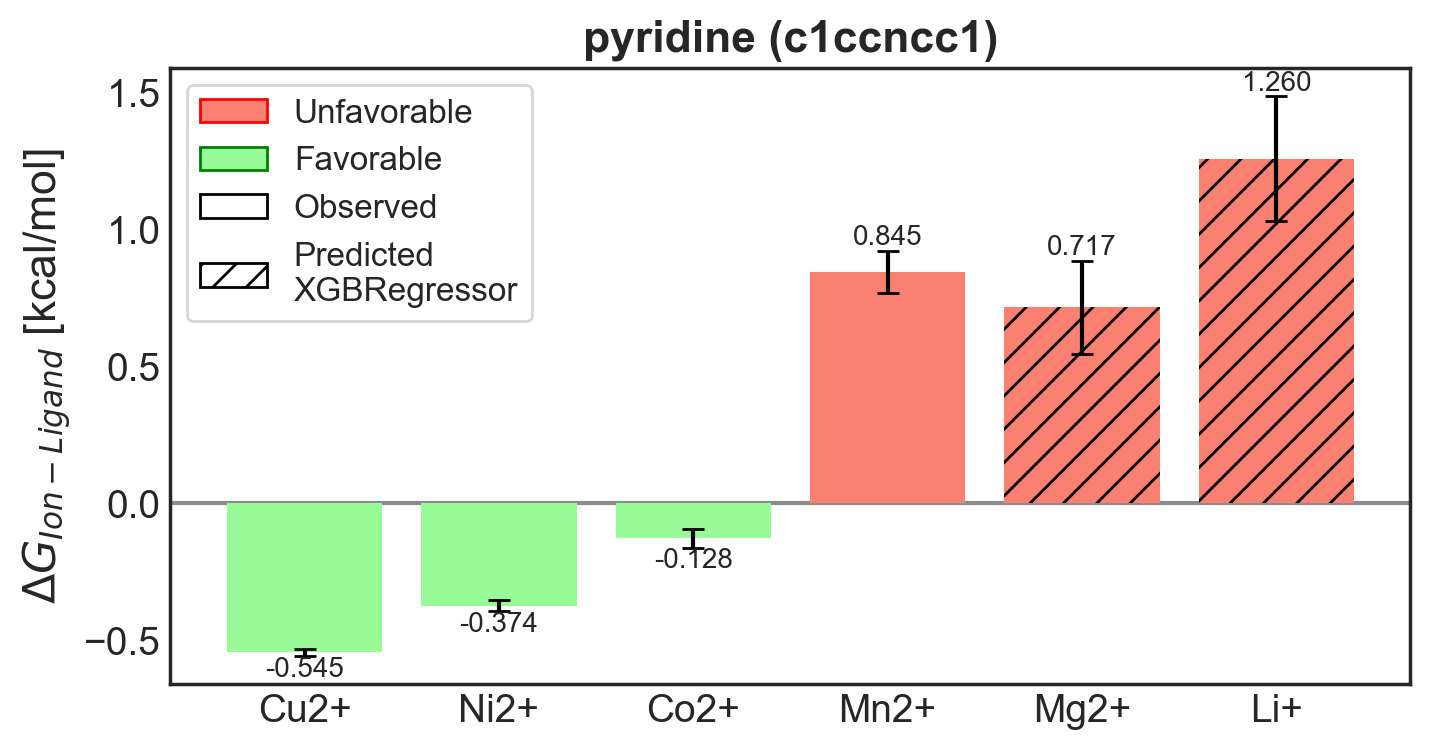

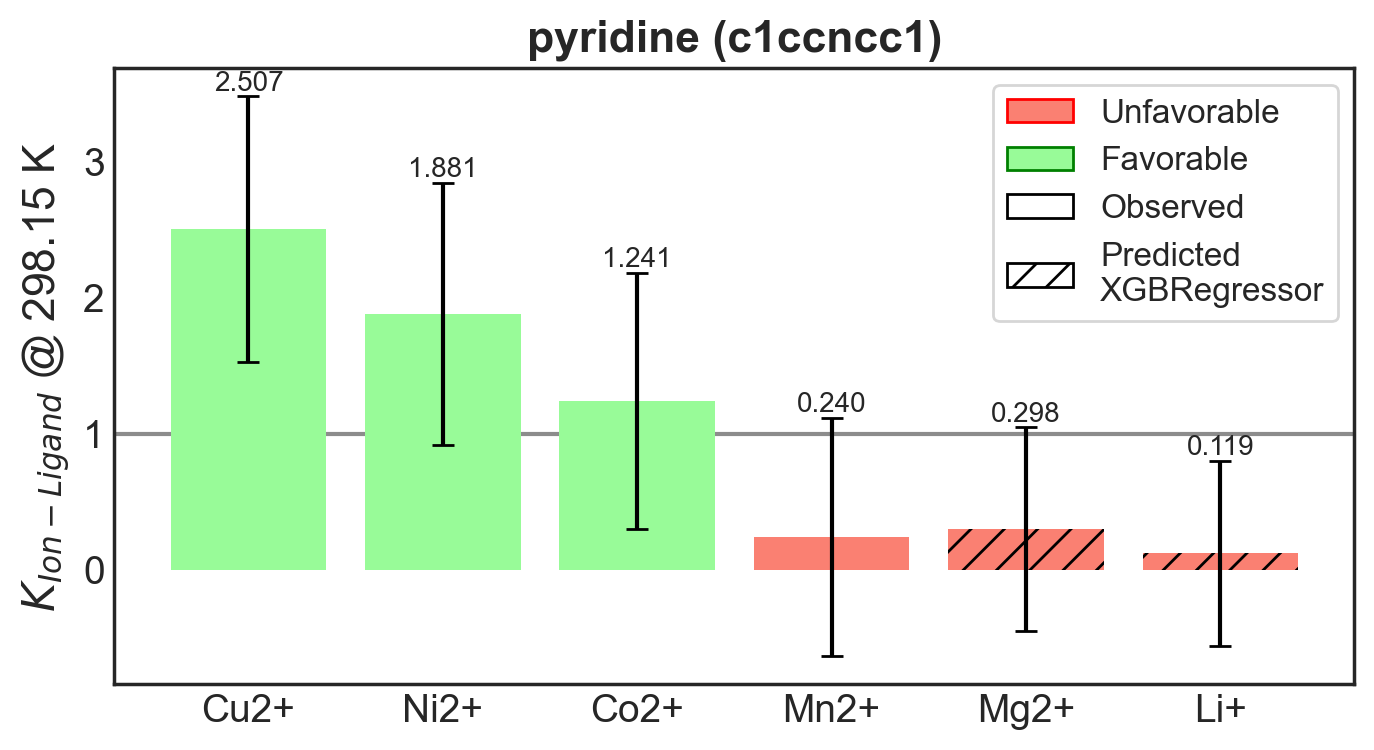

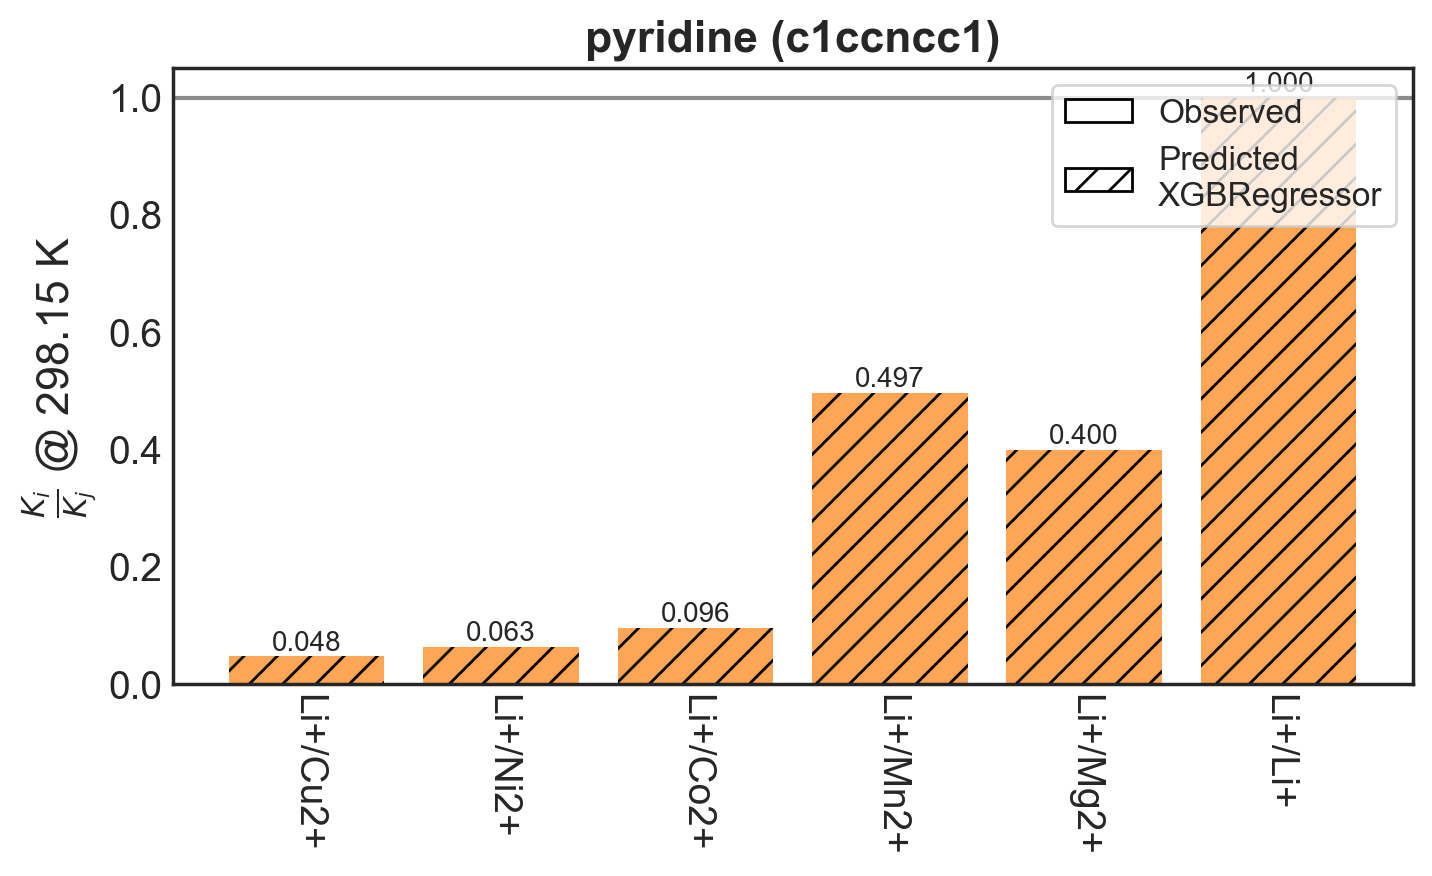

,Electrophile,dG_mean [kcal/mol],dG_std [kcal/mol],observed,K,kpk,Ki/Kj
0,Cu2+,-0.544593,0.014072,True,2.507438,Li+/Cu2+,0.047565
1,Ni2+,-0.374170,0.020430,True,1.880601,Li+/Ni2+,0.063419
2,Co2+,-0.127930,0.033733,True,1.241032,Li+/Co2+,0.096103
3,Mn2+,0.845458,0.077300,True,0.240000,Li+/Mn2+,0.496943
4,Mg2+,0.716779,0.170554,False,0.298225,Li+/Mg2+,0.399921
5,Li+,1.259728,0.228217,False,0.119266,Li+/Li+,1.000000


In [10]:
for l, iupac in lois_zip:
    print()
    print(iupac, l)
    mol = Chem.MolFromSmiles(l)
    display(mol)
    norm_index = None

    # 1 -- filter constructed dataset data, if data doesn't exist, construct input
    # data and make prediction.
    df_l = df_dG[df_dG['smiles'] == l]
    df_sum = pd.DataFrame()
    
    if df_l.shape[0] == 0:
        #print('Empty Dataset')

        l_feats, feat_names = encode_molecule(l)
        l_feats_zip = list(zip(l_feats, feat_names))
        l_feats_zip = [j for j in l_feats_zip if j[1] in l_features]
        l_feats, feat_names = [j[0] for j in l_feats_zip], [l[1] for j in l_feats_zip]
        #print(l_feats_zip)

        df_l = pd.DataFrame()
        df_l.loc[0, 'smiles'] = l

        for e in e_set:
            e_features = df_e[df_e['Electrophile'] == e][ep_features].values
            
            input_features = np.concatenate((l_feats, e_features.flatten())).reshape(1, -1)

            predicted_dG = model.predict(input_features)[0]
            dG_std = model_rmse_ligand_out_of_set_error
            observed = False

            df_l.loc[0, e+' observed'] = observed
            df_l.loc[0, e+' dG_mean [kcal/mol]'] = predicted_dG
            df_l.loc[0, e+' dG_std [kcal/mol]'] = dG_std

    # 2 -- Plot the results as dG data, K, data, and Ki/Kj data

    ### Figure 1 -- dG
    x = e_set
    y1 = [] # dG_mean
    y2 = [] # dG_std
    y3 = [] # observed or predicted data

    for i, e in enumerate(e_set):
        y1.append(df_l[e + ' dG_mean [kcal/mol]'].values[0])

        observed = df_l[e + ' observed'].values[0]
        y3.append(observed)

        y2.append(df_l[e + ' dG_std [kcal/mol]'].values[0])
        
        if e == e_part:
            norm_index = i

    df_sum['Electrophile'] = x
    df_sum['dG_mean [kcal/mol]'] = y1
    df_sum['dG_std [kcal/mol]'] = y2
    df_sum['observed'] = y3

    # format the bars
    hatches = []
    for i in y3:
        if i:
            hatches.append("")
        else:
            hatches.append("//")

    colors = []
    for i in y1:
        if i > 0:
            colors.append('salmon')
        else:
            colors.append('palegreen')

    fig, axs = plt.subplots(1, figsize=(8,4), dpi=200)
    p = axs.bar(x, y1, yerr=y2, capsize=4.0, hatch=hatches, color=colors)
    axs.bar_label(p, fmt='%.3f')
    axs.axhline(0, color='grey', alpha=0.9, linestyle='-', zorder=0)
    
    # format the plot
    axs.set_title(f"{iupac} ({l})",
                  fontsize=16, fontweight='bold')
    axs.set_ylabel(r"$\Delta G_{Ion-Ligand}$ [kcal/mol]")
    #axs.xaxis.set_tick_params(rotation=-90)

    # add the legend
    legend_elements = [Patch(facecolor='salmon', edgecolor='r', label='Unfavorable'),
                       Patch(facecolor='palegreen', edgecolor='g', label='Favorable'),
                       Patch(facecolor='white', edgecolor='k', label='Observed'),
                       Patch(facecolor='white', edgecolor='k', hatch='//', label=f'Predicted\n{model_class}')]

    axs.legend(handles=legend_elements, loc='best', fontsize=12, frameon=True)

    fig.show()
    
    ### Figure 2 -- Ki
    y1_K = [dG_to_K(i) for i in y1]
    y2_K = [dG_to_K(i) for i in y2]
    y3_K = y3

    df_sum['K'] = y1_K

    # format the bars
    hatches = []
    for i in y3_K:
        if i:
            hatches.append("")
        else:
            hatches.append("//")

    colors = []
    for i in y1_K:
        if i < 1.0:
            colors.append('salmon')
        else:
            colors.append('palegreen')
    
    fig, axs = plt.subplots(1, figsize=(8,4), dpi=200)
    p = axs.bar(x, y1_K, yerr=y2_K, capsize=4.0, hatch=hatches, color=colors)
    axs.bar_label(p, fmt='%.3f')
    axs.axhline(1.0, color='grey', alpha=0.9, linestyle='-', zorder=0)

    # format the plot
    axs.set_title(f"{iupac} ({l})",
                  fontsize=16, fontweight='bold')
    axs.set_ylabel(r"$K_{Ion-Ligand}$ @ " + f"{T} K")

    # add the legend
    legend_elements = [Patch(facecolor='salmon', edgecolor='r', label='Unfavorable'),
                       Patch(facecolor='palegreen', edgecolor='g', label='Favorable'),
                       Patch(facecolor='white', edgecolor='k', label='Observed'),
                       Patch(facecolor='white', edgecolor='k', hatch='//', label=f'Predicted\n{model_class}')]

    axs.legend(handles=legend_elements, loc='upper right', fontsize=12, frameon=True)

    fig.show()

    ### Figure 3 -- Ki/Kj
    norm_k_val = y1_K[norm_index]
    norm_observed = y3_K[norm_index]
    x_kpk = [f"{e_part}/{i}" for i in x]
    y1_kpk = [norm_k_val/i for i in y1_K]
    y3_kpk = [(norm_observed and i) for i in y3_K]

    df_sum['kpk'] = x_kpk 
    df_sum['Ki/Kj'] = y1_kpk

    hatches = []
    for i in y3_kpk:
        if i:
            hatches.append("")
        else:
            hatches.append("//")

    colors = []
    for i in y1_kpk:
        if i < 1.0:
            colors.append('salmon')
        else:
            colors.append('palegreen')
    
    fig, axs = plt.subplots(1, figsize=(8,4), dpi=200)
    p = axs.bar(x_kpk, y1_kpk, hatch=hatches, color='tab:orange', alpha=0.7)
    axs.bar_label(p, fmt='%.3f')
    axs.axhline(1.0, color='grey', alpha=0.9, linestyle='-', zorder=0)

    # format the plot
    axs.set_title(f"{iupac} ({l})",
                  fontsize=16, fontweight='bold')
    axs.set_ylabel(r"$\frac{K_i}{K_j}$ @ " + f"{T} K")
    axs.tick_params(axis='x', rotation=-90)

    # add the legend
    legend_elements = [Patch(facecolor='white', edgecolor='k', label='Observed'),
                       Patch(facecolor='white', edgecolor='k', hatch='//', label=f'Predicted\n{model_class}')]

    axs.legend(handles=legend_elements, loc='upper right', fontsize=12, frameon=True)

    plt.show()

    if show_dfs:
        display(df_sum)
        print()
    print()